#DATASCI W261: Machine Learning at Scale

##Version 1: One MapReduce Stage (join data at the first reducer)

# Data Generation

Data Information:
+ Sizes: 1000 points
+ True model: y = 1.0 * x - 4
+ Noise：Normal Distributed mean = 0, var = 5

In [2]:
%matplotlib inline
import numpy as np
import pylab 
size = 1000
x = np.random.uniform(-40, 40, size)
y = x * 1.0 - 4 + np.random.normal(0,5,size)
data = zip(range(size),y,x)
#data = np.concatenate((y, x), axis=1)
np.savetxt('LinearRegression.csv',data,'%i,%f,%f')

In [8]:
data[:10]

[(0, 23.40928888427073, 32.917736564723114),
 (1, -30.253929548099201, -22.528345789897692),
 (2, 27.355626210091412, 28.440955855415808),
 (3, 21.808265765521085, 28.651135064922983),
 (4, -23.811553286406987, -24.563903354053032),
 (5, 19.985720829182519, 29.155013044605937),
 (6, -8.4248008896541489, -12.196508190731727),
 (7, 25.875857677304069, 26.31072814104013),
 (8, -45.575642601474954, -32.493931947624404),
 (9, 12.484475640241072, 14.902657917174345)]

# Data Visualiazation

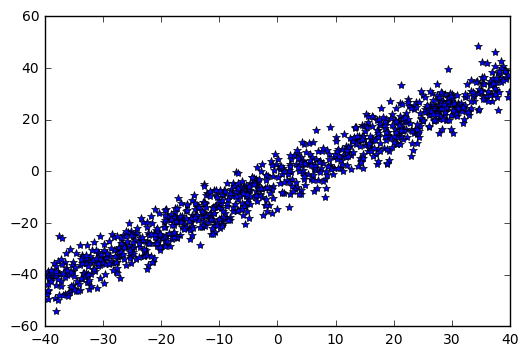

In [3]:
pylab.plot(x, y,'*')
pylab.show()

# MrJob class code

The solution of linear model $$ \textbf{Y} = \textbf{X}\theta $$ is:
$$ \hat{\theta} = (\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T\textbf{y} $$
If $\textbf{X}^T\textbf{X}$ is denoted by $A$, and $\textbf{X}^T\textbf{y}$ is denoted by $b$, then
$$ \hat{\theta} = A^{-1}b $$
There are two MrJob classes to calculate intermediate results:
+ linearRegressionXSquare.py calculates $A = \textbf{X}^T\textbf{X}$
+ linearRegressionXy.py calculates $b = \textbf{X}^T\textbf{y}$

In [4]:
%%writefile linearRegressionXSquare.py
#Version 1: One MapReduce Stage (join data at the first reducer)
from mrjob.job import MRJob

class MRMatrixX2(MRJob):
    #Emit all the data need to caculate cell i,j in result matrix
    def mapper(self, _, line):
        v = line.split(',')
        # add 1s to calculate intercept
        v.append('1.0')
        for i in range(len(v)-2):
            for j in range(len(v)-2):
                yield (j,i),(int(v[0]),float(v[i+2]))
                yield (i,j),(int(v[0]),float(v[i+2]))
                
    # Sum up the product for cell i,j
    def reducer(self, key, values):
        idxdict = {}
        s = 0.0
        preidx = -1
        preval = 0
        f = []
        for idx, value in values:
            if str(idx) in idxdict:
                s = s + value * idxdict[str(idx)]
            else:
                idxdict[str(idx)] = value
        yield key,s

if __name__ == '__main__':
    MRMatrixX2.run()

Writing linearRegressionXSquare.py


In [5]:
%%writefile linearRegressionXy.py
from mrjob.job import MRJob

class MRMatrixXY(MRJob):
    def mapper(self, _, line):
        v = line.split(',')
        # product of y*xi
        for i in range(len(v)-2):
            yield i, float(v[1])*float(v[i+2])
        # To calculate Intercept
        yield i+1, float(v[1])
    
    # Sum up the products
    def reducer(self, key, values):
        yield key,sum(values)

if __name__ == '__main__':
    MRMatrixXY.run()

Writing linearRegressionXy.py


# Driver:

Driver run tow MrJob class to get $\textbf{X}^T\textbf{X}$ and $\textbf{X}^T\textbf{y}$. And it calculate $(\textbf{X}^T\textbf{X})^{-1}$ by numpy.linalg.solve. 

In [12]:
from numpy import linalg,array,empty
from linearRegressionXSquare import MRMatrixX2
from linearRegressionXy import MRMatrixXY
mr_job1 = MRMatrixX2(args=['LinearRegression.csv'])
mr_job2 = MRMatrixXY(args=['LinearRegression.csv'])

X_Square = []
X_Y = []
# Calculate XT*X Covariance Matrix
print "Matrix XT*X:"
with mr_job1.make_runner() as runner: 
    # Run MrJob MatrixMultiplication Job
    runner.run()
    # Extract the output I.E. ship data to driver be careful if data you ship is too big
    for line in runner.stream_output():
        key,value =  mr_job1.parse_output_line(line)
        X_Square.append((key,value))
        print key, value
print " " 
# Calculate XT*Y
print "Vector XT*Y:"
with mr_job2.make_runner() as runner: 
    runner.run()
    for line in runner.stream_output():
        key,value =  mr_job2.parse_output_line(line)
        X_Y.append((key,value))
        print key, value
print " "    

#Local Processing the output from two MrJob
n = len(X_Y)
if(n*n!=len(X_Square)):
    print 'Error!'
else:
    XX = empty(shape=[n,n])
    for v in X_Square:
        XX[v[0][0],v[0][1]] = v[1]
    XY = empty(shape=[n,1])
    for v in X_Y:
        XY[v[0],0] = v[1]

print XX
print
print XY
        
theta = linalg.solve(XX,XY)
print "Coefficients:",theta[0,0],',',theta[1,0]

Matrix XT*X:
[0, 0] 524534.732204
[0, 1] -580.443195
[1, 0] -580.443195
[1, 1] 1000.0
 
Vector XT*Y:
0 526932.951368
1 -4304.993382
 
[[ 524534.7322035    -580.443195 ]
 [   -580.443195     1000.       ]]

[[ 526932.95136843]
 [  -4304.993382  ]]
Coefficients: 1.00045084002 , -3.72428849998


# Gradient descent - doesn't work

In [13]:
%%writefile MrJobBatchGDUpdate_LinearRegression.py
from mrjob.job import MRJob

# This MrJob calculates the gradient of the entire training set 
#     Mapper: calculate partial gradient for each example  
#     
class MrJobBatchGDUpdate_LinearRegression(MRJob):
    # run before the mapper processes any input
    def read_weightsfile(self):
        # Read weights file
        with open('weights.txt', 'r') as f:
            self.weights = [float(v) for v in f.readline().split(',')]
        # Initialze gradient for this iteration
        self.partial_Gradient = [0]*len(self.weights)
        self.partial_count = 0
    
    # Calculate partial gradient for each example 
    def partial_gradient(self, _, line):
        D = (map(float,line.split(',')))
        # y_hat is the predicted value given current weights
        y_hat = self.weights[0]+self.weights[1]*D[1]
        # Update parial gradient vector with gradient form current example
        self.partial_Gradient =  [self.partial_Gradient[0]+ D[0]-y_hat, self.partial_Gradient[1]+(D[0]-y_hat)*D[1]]
        self.partial_count = self.partial_count + 1
        #yield None, (D[0]-y_hat,(D[0]-y_hat)*D[1],1)
    
    # Finally emit in-memory partial gradient and partial count
    def partial_gradient_emit(self):
        yield None, (self.partial_Gradient,self.partial_count)
        
    # Accumulate partial gradient from mapper and emit total gradient 
    # Output: key = None, Value = gradient vector
    def gradient_accumulater(self, _, partial_Gradient_Record): 
        total_gradient = [0]*2
        total_count = 0
        for partial_Gradient,partial_count in partial_Gradient_Record:
            total_count = total_count + partial_count
            total_gradient[0] = total_gradient[0] + partial_Gradient[0]
            total_gradient[1] = total_gradient[1] + partial_Gradient[1]
        yield None, [v/total_count for v in total_gradient]
    
    def steps(self):
        return [self.mr(mapper_init=self.read_weightsfile,
                       mapper=self.partial_gradient,
                       mapper_final=self.partial_gradient_emit,
                       reducer=self.gradient_accumulater)] 
    
if __name__ == '__main__':
    MrJobBatchGDUpdate_LinearRegression.run()

Writing MrJobBatchGDUpdate_LinearRegression.py


In [20]:
from numpy import random, array
from MrJobBatchGDUpdate_LinearRegression import MrJobBatchGDUpdate_LinearRegression

learning_rate = 0.05
stop_criteria = 0.000005

# Generate random values as inital weights
weights = array([random.uniform(-3,3),random.uniform(-3,3)])

# Write the weights to the files
with open('weights.txt', 'w+') as f:
    f.writelines(','.join(str(j) for j in weights))


# Update centroids iteratively
i = 0
while(1):
    # create a mrjob instance for batch gradient descent update over all data
    mr_job = MrJobBatchGDUpdate_LinearRegression(args=['--file', 'weights.txt', 'LinearRegression.csv'])
    
    print "iteration ="+str(i)+"  weights =",weights
    # Save weights from previous iteration
    weights_old = weights
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            # value is the gradient value
            key,value =  mr_job.parse_output_line(line)
            # Update weights
            weights = weights - learning_rate*array(value)
    i = i + 1
    if i>100: break
    # Write the updated weights to file 
    with open('weights.txt', 'w+') as f:
        f.writelines(','.join(str(j) for j in weights))
    # Stop if weights get converged
    if(sum((weights_old-weights)**2)<stop_criteria):
        break
        
print "Final weights\n"
print weights

iteration =0  weights = [ 0.19038759 -2.42536914]
iteration =1  weights = [-24.25303313  35.50722028]
iteration =2  weights = [  -58.0836022   1155.67503173]
iteration =3  weights = [  -334.72145048  34086.6844126 ]
iteration =4  weights = [   -7713.58006353  1002047.25717058]
iteration =5  weights = [  -223814.57459511  29453721.0403005 ]
iteration =6  weights = [ -6.57493399e+06   8.65745611e+08]
iteration =7  weights = [ -1.93255162e+08   2.54472210e+10]
iteration =8  weights = [ -5.68042385e+09   7.47980754e+11]
iteration =9  weights = [ -1.66967055e+11   2.19857095e+13]
iteration =10  weights = [ -4.90773210e+12   6.46235105e+14]
iteration =11  weights = [ -1.44255011e+14   1.89950573e+16]
iteration =12  weights = [ -4.24014755e+15   5.58329620e+17]
iteration =13  weights = [ -1.24632421e+17   1.64112148e+19]
iteration =14  weights = [ -3.66337260e+18   4.82381664e+20]
iteration =15  weights = [ -1.07679035e+20   1.41788449e+22]
iteration =16  weights = [ -3.16505466e+21   4.16764

# Kmeans